# 데이터셋 분석 및 모델 생성 코드 분석

### 항해 선박 이동 경로 빅데이터 /AI 예측 웹 서비스


### 요약
해당 문서는 항해 선박 이동 경로 빅데이터 /AI 예측 웹 서비스를 위해 위해 만든 데이터셋을 분석하는 과정과, 데이터 모델 제작에 관한 코드를 모아 놓은 보고서입니다.

###  목적
AIS 데이터는 선박의 속도에 따라 동적 정보(위치,속도,코스)의 전송 주기(Reporting Time)가 정해져 있으므로 전송 주기 사이에 존재하는 선박의 위치는 바로 직전의 정보를 물리 계산식을 통해 단순예측할 수 밖에 없음. AIS 및 해양기상데이터를 학습하여 전송 구간 사이에 최적의 선박위치를 웹서비스로 표출  
- 입력 데이터 : AIS 데이터, 해양 기상 데이터(풍향, 풍속, 파고, 유향, 유속, 기온 ...)
- 출력 데이터 : 해당 선박의 현재 경위도 좌표, 속도,방향
- 제한 : 여러 선박 종류들 중에서 2가지로 한정(어선, 화물선, 여객선 등), 선박의 크기(가로, 세로) 한정  

### 요구사항 
 1.  수신되는 신호를 기반으로 선박들의 현재 위치를 전시
 2.  5분이 지나도 신호가 수신되지 않는 선박에 대해서는 위치를 예측하여 전시.
 3.  다시 신호가 들어오면 해당 신호의 위치를 표출
 4.  AIS 소실 시 항해 경로를 예측하여 예측한 데이터를 지도에 표시


## 1.데이터 수집 및 분석,전처리 


#### 1) AIS 데이터 분석
- 소스데이터 세트 (GC / 건수):(초)당 실시간으로 들어오는 AIS 데이터에서의 mmis(해상이동업무식별번호),ship_name,ship_type,time,위도,cog,sog,경도 정보 관련 GC(AIS)데이터를 분석,결측치 및 이상치를 확인 후 해당사항 처리

- time:1683613053941 mmsi:440135000 shipType:90 shipName:SAE NURI posX:129.3960644030396 posY:34.85181069187095
time:1683613054216 mmsi:273353060 shipType:0 shipName: posX:129.32199830786394 posY:34.95489321184083
time:1683613054441 mmsi:413996000 shipType:0 shipName: posX:129.16234073241736 posY:34.893753305348206
time:1683613055009 mmsi:636092792 shipType:0 shipName: posX:129.68934637699894 posY:35.0224762771314
time:1683613055989 mmsi:440105680 shipType:0 shipName: posX:129.39939715274366 posY:34.98919584890286
time:1683613056111 mmsi:440067880 shipType:0 shipName: posX:129.2775676339114 posY:34.95364155652375
time:1683613056433 mmsi:440120421 shipType:0 shipName: posX:129.18929019094097 posY:34.89292807288728
time:1683613056683 mmsi:440061280 shipType:0 shipName: posX:129.18451115362944 posY:35.016686470294616
time:1683613057125 mmsi:477326200 shipType:0 shipName: posX:129.24631524517685 posY:34.98871747743862
time:1683613057191 mmsi:241632000 shipType:89 shipName:SEA DOLPHIN posX:129.43364991452717 posY:35.03885030886937
time:1683613057628 mmsi:636022727 shipType:82 shipName:TRADER III posX:129.33268825974497 posY:34.8882344056207
time:1683613057748 mmsi:440154010 shipType:0 shipName: posX:129.1809897577157 posY:35.01581097462178
time:1683613057810 mmsi:229047000 shipType:70 shipName:JETSTREAM posX:129.24625236310698 posY:34.864909461679545
time:1683613057952 mmsi:311698000 shipType:0 shipName: posX:129.25571162304877 posY:34.8516632543422
time:1683613058486 mmsi:357104000 shipType:0 shipName: posX:129.6675712145119 posY:35.099676161538746
time:1683613058851 mmsi:440135000 shipType:90 shipName:SAE NURI posX:129.396324914472 posY:34.85204659136741
time:1683613059332 mmsi:273394340 shipType:70 shipName:PATRIA posX:129.50196679188446 posY:34.921091810459636
time:1683613060707 mmsi:511100559 shipType:0 shipName: posX:129.33936274230595 posY:34.97639660933228
time:1683613060983 mmsi:477832100 shipType:0 shipName: posX:129.94774676847592 posY:35.03793091962549
time:1683613061411 mmsi:352001904 shipType:0 shipName: posX:129.2705428083896 posY:34.92490713215991 ......

-  해당 실시간 AIS데이터를 postgis를 이용하여 csv파일로 해당 데이터 가져오기


In [8]:
import csv

df = 'D:/장우영/LOCALSEARCH\DA\DA\data/Ais_Test.xlsx'
ais_data = pd.read_excel(df)
print(ais_data)

            mmsi      ship_name  ship_type   
0      440051540           D-01          0  \
1      440300780            NaN          0   
2      440208550            NaN          0   
3      440275000  GBK EXPRESS 1         40   
4      440414850   NO1 GEO SUNG         80   
...          ...            ...        ...   
16180  538010219  SAWASDEE VEGA         70   
16181  440121850            NaN          0   
16182  440110850  PILOT ORYUKDO         50   
16183  440107840   NO.7 GEUMHWA         30   
16184  440134620       HYUNJUNG         80   

                                                    geom    cog   sog   
0      0101000020110F00000000002039676B41000000002DCF...  329.2   5.7  \
1      0101000020110F0000000000C0D2666B410000008079E5...  329.8   0.0   
2      0101000020110F00000000002062656B4100000080F0DD...  139.3   0.0   
3      0101000020110F000000000040A1666B41000000800AE4...  175.8   0.0   
4      0101000020110F00000000004097666B410000008067E5...    0.0   0.0   
...      

![](../data_image/AIS%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%B4%EB%AF%B8%EC%A7%80.PNG)

#### 2) 기상청 데이터 분석
-국립 해양측위정보원에서의 실시간  해양기상 통계자료 중 선박 이동 경로에 영향을 미치는 기상 요인(예:풍향, 유향, 기온, 수온,풍속,유속,기압,습도)만 선택하여 사용

- 기상청 데이터: https://marineweather.nmpnt.go.kr/statistic/searchStatisticList.do
- 1차: 다양한 값이 측정이 되어 있는 부산청 => 신항유도등부표(랜비)의 등대 기상청 데이터를 사용 

In [4]:
import pandas as pd
import numpy as np

excel_file = 'D:/장우영/LOCALSEARCH\DA\DA\data/05_11 기상청 데이터.xls'

weather_data = pd.read_excel(excel_file)


# 데이터 확인 
print(weather_data)
print(weather_data.shape) # 144,11
print(weather_data.head(5))

     지방청           표지                일시  풍향(˚)  유향(˚)  기온(℃)  수온(℃)  풍속(m/s)   
0    부산청  신항유도등부표(랜비)  2023-05-11 23:50    100     80   15.9   16.5    2.570  \
1    부산청  신항유도등부표(랜비)  2023-05-11 23:40    114     78   16.7   16.3    1.540   
2    부산청  신항유도등부표(랜비)  2023-05-11 23:30    114     94   15.8   16.4    1.540   
3    부산청  신항유도등부표(랜비)  2023-05-11 23:20    150     92   16.0   16.6    0.514   
4    부산청  신항유도등부표(랜비)  2023-05-11 23:10    142     74   17.0   16.6    1.030   
..   ...          ...               ...    ...    ...    ...    ...      ...   
139  부산청  신항유도등부표(랜비)  2023-05-11 00:40    150    125   14.6   16.6    0.000   
140  부산청  신항유도등부표(랜비)  2023-05-11 00:30    142    146   14.5   16.8    0.000   
141  부산청  신항유도등부표(랜비)  2023-05-11 00:20    149    100   15.5   16.9    0.514   
142  부산청  신항유도등부표(랜비)  2023-05-11 00:10    157    103   16.1   17.0    0.000   
143  부산청  신항유도등부표(랜비)  2023-05-11 00:00    184     68   15.1   16.9    0.514   

     유속(kn)  기압(hPa)  습도(%)  
0       0

![](../data_image/%EA%B8%B0%EC%83%81%EC%B2%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%9D%B4%EB%AF%B8%EC%A7%80.PNG)

In [5]:
# NaN (결측치)값 확인
print(weather_data.isna().sum())

지방청        0
표지         0
일시         0
풍향(˚)      0
유향(˚)      0
기온(℃)      0
수온(℃)      0
풍속(m/s)    0
유속(kn)     0
기압(hPa)    0
습도(%)      0
dtype: int64


#### 3) AIS 데이터와 기상청에서 제공하는 해양 기상 데이터를 이용하여 입력 데이터와 출력 데이터를 구성
-          독립변수 :  풍향,유향,기온,풍속,유속,기압,습도(기상청데이터)
			  		  mmsi(AIS데이터),선박의 위치(위도, 경도), cog(이동하는 방향각), sog(수신기가 이동하는 속도)
					  
-          종속변수 : 선박의 위치(위도, 경도), cog(이동하는 방향각), sog(수신기가 이동하는 속도)

#### 4) 해당 데이터 모델을 시간을 기준으로 데이터를 병합
- AIS 데이터셋과 기상청 데이터셋을 모두 일시(시간)이 있어서 초단위인 AIS 데이터 시간을 기준(초 단위)으로 자바를 이용하여 데이터를 병합 
- AIS 데이터셋이 기준: 데이터 손실을 막기 위해

- 시간에 따라 이러한 데이터 포인트를 시퀀스 형태로 모아 모델의 입력으로 사용하기

- AData 객체의 cust_time과 FData 객체의 ilsi 필드 사이에서 가장 가까운 시간을 가지고 있는 FData 객체가 병합됩니다.
- AIS Adata cust_time인 2023-05-11 10:19:59와 Fdata 일시 ilsi인 2023-05-11 10:10:00 사이에서 가장 가까운 시간을 가지는 FData 객체가 병합


package com.gc;

import java.io.BufferedReader;
import java.io.BufferedWriter;
import java.io.FileOutputStream;
import java.io.FileReader;
import java.io.IOException;
import java.io.OutputStreamWriter;
import java.text.SimpleDateFormat;
import java.time.LocalDateTime;
import java.time.format.DateTimeFormatter;
import java.util.ArrayList;
import java.util.Date;

// 지방청	표지	일시	풍향(˚)	유향(˚)	기온(℃)	수온(℃)	풍속(m/s)	유속(kn)	기압(hPa)	습도(%)

public class DataMergeMainBackup {
	// ==============================================================================================

	// 2023-05-11 10:10:58의 데이터 형식을 올바르게 출력하기 위한 코드 => 날짜 및 시간의 문자열 표현을 개체로 변환하는
	// Util 유틸리티 메서드
	class Util {
		public static LocalDateTime stringtoDate(String str, String pattern) {
			DateTimeFormatter formatter = DateTimeFormatter.ofPattern(pattern);
			return LocalDateTime.parse(str, formatter);
		}

	}

	// 기상청 데이터
	class FData {
		String govName; // 지방청
		String pyogi; // 표지
		LocalDateTime ilsi; // 날짜 및 시간(일시)
		int windDir; // 풍향
		int waveDir; // 유향
		double airTemp; // 기온
		double waterTemp; // 수온
		double windSpeed; // 풍속
		double waterSpeed; // 유속
		int hPa; // 기압
		int humidity; // 습도
		String source;

		public FData(String str) {
			source = str;
			// 문자열을 구문 분석
			String[] array = str.split(",");
			govName = array[0];
			pyogi = array[1];
			ilsi = Util.stringtoDate(array[2], "yyyy-MM-dd HH:mm");
			// windDir의 형식이 int이기 때문에 =>
			if (array[3].length() == 0) // 만약 windDir의 값이 없으면 => 0
				windDir = 0; // 바람의 방향이 없음
			else // 있다면 값을 넣어줌
				windDir = Integer.parseInt(array[3]);
			if (array[4].length() == 0)
				waveDir = 0;
			else
				waveDir = Integer.parseInt(array[4]);
			if (array[5].length() == 0)
				airTemp = 0.0;
			else
				airTemp = Double.parseDouble(array[5]);
			if (array[6].length() == 0)
				waterTemp = 0.0;
			else
				waterTemp = Double.parseDouble(array[6]);
			if (array[7].length() == 0)
				windSpeed = 0.0;
			else
				windSpeed = Double.parseDouble(array[7]);
			if (array[8].length() == 0)
				waterSpeed = 0.0;
			else
				waterSpeed = Double.parseDouble(array[8]);
			if (array[9].length() == 0)
				hPa = 0;
			else
				hPa = Integer.parseInt(array[9]);
			if (array[10].length() == 0)
				humidity = 0;
			else
				humidity = Integer.parseInt(array[10]);
		}

		@Override
		public String toString() {
			return "FData [govName=" + govName + ", pyogi=" + pyogi + ", ilsi=" + ilsi + ", windDir=" + windDir
					+ ", waveDir=" + waveDir + ", airTemp=" + airTemp + ", waterTemp=" + waterTemp + ", windSpeed="
					+ windSpeed + ", waterSpeed=" + waterSpeed + ", hPa=" + hPa + ", humidity=" + humidity + "]";
		}

	}

//	 	mmsi	ship_name	ship_type	geom	cog		sog		insert_time

	// GC AIS데이터
	class AData {
		String mmsi; // mmis
		String ship_name; // 선박 이름
		int ship_type; // 선박 유형
		String geom; // 경도 위도
		double cog; // 지상 코스
		double sog; // 지상 속도
		LocalDateTime insert_time; // 데이터가 들어온 시간
		LocalDateTime cust_time; // 데이터가 들어온 시간에서 초를 뺸 시간
		FData fdata;
		String source;

		public AData(String str) {
			// 문자열을 구문 분석
			source = str;
			String[] array = str.split(",");
			mmsi = array[0];
			ship_name = array[1];
			if (array[2].length() == 0)
				ship_type = 0;
			else
				ship_type = Integer.parseInt(array[2]);
			geom = array[3];
			if (array[4].length() == 0)
				cog = 0;
			else
				cog = Double.parseDouble(array[4]);
			if (array[5].length() == 0)
				sog = 0;
			else
				sog = Double.parseDouble(array[5]);
			insert_time = Util.stringtoDate(array[6], "yyyy-MM-dd HH:mm:ss");

			// 삽입 시간 값의 일부를 추출 => yyyy-MM-dd HH:mm
			// 초 자리 표시자로 "0"을 추가하여 삽입 시간 값을 수정
			String t = array[6].substring(0, array[6].length() - 4) + "0";
			cust_time = Util.stringtoDate(t, "yyyy-MM-dd HH:mm");

		}

		@Override
		public String toString() {
			return "AData [mmsi=" + mmsi + ", ship_name=" + ship_name + ", ship_type=" + ship_type + ", geom=" + geom
					+ ", cog=" + cog + ", sog=" + sog + ", insert_time=" + insert_time + ", cust_time=" + cust_time
					+ "]";
		}

	}

	// 기상청 데이터
	ArrayList<FData> FDlist = new ArrayList<>();

	// 일기예보 데이터 읽기 및 저장
	public void readForcastData(String fname) throws Exception {
		System.out.println("readForcastData: " + fname);
		try (BufferedReader br = new BufferedReader(new FileReader(fname));) {
			String str;
			br.readLine();
			while ((str = br.readLine()) != null) {
				// System.out.println(str);
				FData fd = new FData(str);
				FDlist.add(fd);
			}
		}
	}

	public void printForcastData() {
		// System.out.println("printForcastData");
		for (FData fd : FDlist) {
			System.out.println(fd);
		}
	}

	// ==============================================================================================

	// Ais 데이터
	ArrayList<AData> ASlist = new ArrayList<>();

	// Ais 데이터 읽기 및 저장
	public void readAISData(String fname) throws Exception {
		System.out.println("readForcastData: " + fname);
		try (BufferedReader br = new BufferedReader(new FileReader(fname));) {
			String str;
			br.readLine();
			while ((str = br.readLine()) != null) {
				// System.out.println(str);
				AData ad = new AData(str);
				ASlist.add(ad);
			}
		}
	}

	public void printAISData() {
		// System.out.println("printForcastData");
		for (AData ad : ASlist) {
			System.out.println(ad);
		}
	}

	public void printAISTimeDate() {
		for (AData ad : ASlist) {
			System.out.println("insert_time=" + ad.insert_time + ", cust_time=" + ad.cust_time);
		}
	}

//  AISDATA에 FDATA를 mapping하는 코드
	public void mappingData() {
		for (AData ad : ASlist) {
			for (FData fd : FDlist) {
				if (ad.cust_time.equals(fd.ilsi)) {
					ad.fdata = fd;
				}
			}
		}
	}

	public void printMappingData() {

		for (int i = 0; i < 100; i++) {
			AData ad = ASlist.get(i);
			System.out.println("mmsi=" + ad.mmsi + ", cust_time=" + ad.cust_time + ", windDir=" + ad.fdata.windDir
					+ ", waveDir=" + ad.fdata.waveDir);
		}
	}

	public void writeData(String fname) throws IOException {
		// try (BufferedWriter bw = new BufferedWriter(new FileWriter(fname));) {
		try (BufferedWriter bw = new BufferedWriter(new OutputStreamWriter(new FileOutputStream(fname), "KSC5601"));) {

			for (AData ad : ASlist) {
				bw.write(String.format("%s,%s\n", ad.source, ad.fdata.source));
			}
		}
		System.out.println(fname);
	}

	// "D:\장우영\LOCALSEARCH\DA\DA\data" "05_11 기상청 데이터.csv" "Ais_Test.csv"
	public static void main(String[] args) throws Exception {
		DataMergeMainBackup dmn = new DataMergeMainBackup();
		System.out.println(args[0]);
		System.out.println(args[1]);
		System.out.println(args[2]);

		// 일기 예보 데이터의 파일
		dmn.readForcastData(args[0] + "\\" + args[1]);
		// dmn.printForcastData();

		// AIS 데이터의 파일
		dmn.readAISData(args[0] + "\\" + args[2]);
		// dmn.printAISData();
		// dmn.printAISTimeDate();

		// 그런 다음 예보 및 AIS 데이터를 읽고 데이터를 매핑하고 매핑된 데이터를 "FAmerge.csv"라는 파일에 씁니다.
		dmn.mappingData();
		// dmn.printMappingData();
		SimpleDateFormat sdf = new SimpleDateFormat("yyyyMMdd_HHmmss");
		String fname = args[0] + "\\FAmerge_" + sdf.format(new Date()) + ".csv";
		// dmn.writeData("fname");
		dmn.writeData(fname);
		// System.out.println(fname);
		System.out.println("End");
	}

}


- 해당 병합 코드를 이용해서 시간을 기준으로 병합한 csv 파일 만들기
-  CSV 파일에서 예보 데이터와 AIS 데이터를 읽고 공통 시간 값을 기반으로 데이터를 매핑하고 매핑된 데이터를 새 CSV 파일에 씁니다

In [6]:
import pandas as pd
data = pd.read_csv('D:/장우영/LOCALSEARCH/DA/DA/data/FAmerge_20230602_101301.csv', encoding='ANSI')
#print(data)
print(data.head(5))

# 2023.05.11 10시 10분 ~ 2023.05.11 11시 20분 (1시간 10분 데이터)

        mmsi      ship_name  ship_type   
0  440051540           D-01          0  \
1  440300780            NaN          0   
2  440208550            NaN          0   
3  440275000  GBK EXPRESS 1         40   
4  440414850   NO1 GEO SUNG         80   

                                                geom    cog  sog   
0  0101000020110F00000000002039676B41000000002DCF...  329.2  5.7  \
1  0101000020110F0000000000C0D2666B410000008079E5...  329.8  0.0   
2  0101000020110F00000000002062656B4100000080F0DD...  139.3  0.0   
3  0101000020110F000000000040A1666B41000000800AE4...  175.8  0.0   
4  0101000020110F00000000004097666B410000008067E5...    0.0  0.0   

           insert_time  지방청           표지                   일시   풍향   유향    기온   
0  2023-05-11 10:10:58  부산청  신항유도등부표(랜비)  2023-05-11 10:10:00  196  246  16.4  \
1  2023-05-11 10:10:58  부산청  신항유도등부표(랜비)  2023-05-11 10:10:00  196  246  16.4   
2  2023-05-11 10:10:58  부산청  신항유도등부표(랜비)  2023-05-11 10:10:00  196  246  16.4   
3  2023-05-11 

![](../data_image/101301merge_data.PNG)

In [2]:
import pandas as pd

# CSV 파일 불러오기
data = pd.read_csv('D:/장우영/LOCALSEARCH/DA/DA/data/FAmerge_20230531_103345.csv', encoding='ANSI')

# B열 값을 A열의 값으로 변환
data['일시'] = data['insert_time']

# 변환된 데이터를 새로운 CSV 파일로 저장
data.to_csv('D:/장우영/LOCALSEARCH/DA/DA/data/변환된_파일명.csv',  encoding='ANSI')
print(data.일시)
print(data.insert_time)

0        2023-05-11 10:10:58
1        2023-05-11 10:10:58
2        2023-05-11 10:10:58
3        2023-05-11 10:10:58
4        2023-05-11 10:10:58
                ...         
52732    2023-05-11 11:19:59
52733    2023-05-11 11:19:59
52734    2023-05-11 11:19:59
52735    2023-05-11 11:19:59
52736    2023-05-11 11:19:59
Name: 일시, Length: 52737, dtype: object
0        2023-05-11 10:10:58
1        2023-05-11 10:10:58
2        2023-05-11 10:10:58
3        2023-05-11 10:10:58
4        2023-05-11 10:10:58
                ...         
52732    2023-05-11 11:19:59
52733    2023-05-11 11:19:59
52734    2023-05-11 11:19:59
52735    2023-05-11 11:19:59
52736    2023-05-11 11:19:59
Name: insert_time, Length: 52737, dtype: object


In [38]:
# Load data from CSV file
data = pd.read_csv('D:/장우영/LOCALSEARCH/DA/DA/data/FAmerge_20230531_103345.csv', encoding='ANSI')
print(data.insert_time)

0        2023-05-11 10:10:58
1        2023-05-11 10:10:58
2        2023-05-11 10:10:58
3        2023-05-11 10:10:58
4        2023-05-11 10:10:58
                ...         
52732    2023-05-11 11:19:59
52733    2023-05-11 11:19:59
52734    2023-05-11 11:19:59
52735    2023-05-11 11:19:59
52736    2023-05-11 11:19:59
Name: insert_time, Length: 52737, dtype: object


In [39]:
print(data.shape)

# (52737, 18)

(52737, 18)


- 병합 데이터 분석,전처리 확인 

In [40]:
# NaN 값 확인
print(data.isna().sum())
# shipname의 값  7875개 null

mmsi              0
ship_name      7875
ship_type         0
geom              0
cog               0
sog               0
insert_time       0
지방청               0
표지                0
일시                0
풍향                0
유향                0
기온                0
수온                0
풍속                0
유속                0
기압                0
습도                0
dtype: int64


- AIS 데이터의 geom(좌표값) => 위도,경도 값으로 출력
- geom  = WKB 문자열은 이진 형식의 기하학적 개체(기하학적 문자열)

In [18]:
import binascii
from shapely import wkb
import pyproj

# 주어진 WKB 문자열
wkb_string = '0101000020110F0000000000C093676B4100000000F6E14F41'

# 1단계: 16진수 문자열을 2진수로 디코딩
binary_string = binascii.unhexlify(wkb_string)

# 2단계: 이진 문자열 구문 분석
geometry = wkb.loads(binary_string)

# 3단계: 좌표를 위도와 경도로 변환
if geometry and hasattr(geometry, 'wkt'):
    # WKT(Well-Known Text) 형식으로 변환
    wkt = geometry.wkt

    # 좌표계 변환 정의 3857 => 4326
    crs_from = pyproj.Proj(init='epsg:3857')
    crs_to = pyproj.Proj(init='epsg:4326')

    # 좌표 변환 수행
    transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)

    # 위도와 경도 추출
    latitude, longitude = transformed[1], transformed[0]

    # latitude and longitude 값 출력
    print(latitude, longitude)
else:
    print('"잘못된 기하학 데이터')

 # 35.123838041911526 129.0551896853276
 # 35.11222830013471 129.0684757683797

35.11061897120135 129.0690596733144


c:\Users\SW\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\SW\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\SW\AppData\Local\Temp\ipykernel_5360\11607251.py:24: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#up

- 셈플 데이터 100개 geom => 위도,경도 변환

In [27]:
import pandas as pd
import binascii
from shapely import wkb
import pyproj
from pyproj import Transformer

def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)

        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    

#  CSV 파일에서 데이터 로드
data = pd.read_csv('D:\\장우영\\LOCALSEARCH\\DA\\DA\\data\\FAmerge_20230523_161834_simple.csv', encoding='ANSI',low_memory=False)

# # 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

print(data[['latitude', 'longitude']].head(100))

# "insert_time"을 숫자로 변환
data['insert_time'] = pd.to_datetime(data['insert_time']).astype('int64') // 10**9

# 특성과 타겟 변수 선택
X = data[["mmsi", "ship_type", "latitude", "longitude", "cog", "sog", "insert_time", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]
y = data[["latitude", "longitude", "cog", "sog"]]

print(y)

     latitude   longitude
0   35.039909  129.062547
1   35.123838  129.055190
2   35.095487  129.028698
3   35.118445  129.051632
4   35.123574  129.050914
..        ...         ...
95  35.083028  128.996242
96  34.712431  129.067003
97  35.078323  129.107256
98  35.119371  129.050914
99  35.088622  129.026821

[100 rows x 2 columns]
        latitude   longitude    cog  sog
0      35.039909  129.062547  329.2  5.7
1      35.123838  129.055190  329.8  0.0
2      35.095487  129.028698  139.3  0.0
3      35.118445  129.051632  175.8  0.0
4      35.123574  129.050914    0.0  0.0
...          ...         ...    ...  ...
47994        NaN         NaN    NaN  NaN
47995        NaN         NaN    NaN  NaN
47996        NaN         NaN    NaN  NaN
47997        NaN         NaN    NaN  NaN
47998        NaN         NaN    NaN  NaN

[47999 rows x 4 columns]


# 2. 데이터모델 분석
 ### 1) 선형 회귀 모델 

 - 전반적으로 이 코드는 데이터 전처리, 기능 엔지니어링 및 선형 회귀 모델링을 수행하여 제공된 기능을 기반으로 위도, 경도, 지상 코스(cog) 및 지상 속도(sog)를 예측합니다.

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import binascii
from shapely import wkb
import pyproj
from pyproj import Transformer

# 이 함수는 WKB 문자열을 입력으로 사용하고 다양한 단계를 수행하여 위도 및 경도 좌표로 변환  
def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)

        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    

# 2023.05.11 10시 10분 ~ 2023.05.11 11시 20분 (1시간 10분 데이터)
data = pd.read_csv('D:/장우영/LOCALSEARCH/DA/DA/data/FAmerge_20230531_103345.csv', encoding='ANSI')

# 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

#print(data[['latitude', 'longitude']].head(100))


# 'insert_time'을 숫자 기능으로 변환:
#  datetime접근자를 사용 pd.to_datetime하고 접근자를 사용 하여 'insert_time' 열에서 다양한 시간적 특징(년, 월, 일, 시, 분, 초)을 추출
# data['insert_time'] = pd.to_datetime(data['insert_time']).astype('int64') // 10**9
data['year'] = pd.to_datetime(data['insert_time']).dt.year
data['month'] = pd.to_datetime(data['insert_time']).dt.month
data['day'] = pd.to_datetime(data['insert_time']).dt.day
data['hour'] = pd.to_datetime(data['insert_time']).dt.hour
data['minute'] = pd.to_datetime(data['insert_time']).dt.minute
data['second'] = pd.to_datetime(data['insert_time']).dt.minute

#print(data['insert_time'])

#특성과 타겟 변수 선택 # cog(방향), sog(속도)
X = data[["mmsi", "ship_type", "latitude", "longitude", "cog", "sog", "year", "month", "day", "hour", "minute", "second", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]
y = data[["latitude", "longitude","cog", "sog"]]
print(X)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성 및 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 목표 값 예측
y_pred = model.predict(X_test)

# 평균 오차값 예측
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

            mmsi  ship_type   latitude   longitude    cog  sog  year  month   
0      440051540          0  35.039909  129.062547  329.2  5.7  2023      5  \
1      440300780          0  35.123838  129.055190  329.8  0.0  2023      5   
2      440208550          0  35.095487  129.028698  139.3  0.0  2023      5   
3      440275000         40  35.118445  129.051632  175.8  0.0  2023      5   
4      440414850         80  35.123574  129.050914    0.0  0.0  2023      5   
...          ...        ...        ...         ...    ...  ...   ...    ...   
52732  440314810         80  35.105600  129.090395  347.5  0.1  2023      5   
52733  440001860         80  35.124014  129.051992    0.0  0.0  2023      5   
52734  440117010         80  35.032179  129.042892   53.8  0.1  2023      5   
52735  440101390          0  35.093532  129.025455  254.6  0.0  2023      5   
52736  440233000         60  35.115888  129.049153  360.0  0.0  2023      5   

       day  hour  minute  second   풍향   유향    기온   

- 대상 값 예측: 이 코드는 훈련된 모델을 사용하여 테스트 세트의 대상 값(위도, 경도, COG, SOG)을 예측합니다.

- 평균 제곱 오차(MSE) 계산:mean_squared_error 이 코드는 sklearn의 함수를 사용하여 예측 목표 값과 실제 목표 값 사이의 평균 제곱 오차를 계산합니다 .

- Mean Squared Error: 2.5777660104738737e-23 == 매우 낮은 오차를 달성

- Flask를 사용해서 "/predict" api를 작동하게 만들기
- 확인은 postman사용

In [17]:
import pickle

# 모델 저장
with open('linear_regression_linearmodel_.pkl', 'wb') as file:
    pickle.dump(model, file)

In [16]:
import pickle

# 모델을 불러오기 위해 pickle 파일을 엽니다.
model = pickle.load(open('linear_regression_linearmodel_.pkl', 'rb'))

In [ ]:
from flask import Flask, request, jsonify
import pickle
import pandas as pd

app = Flask(__name__)

# 훈련된 선형 회귀 모델 불러오기
model = pickle.load(open('D:/장우영/LOCALSEARCH/DA/DA/notebooks/linear_regression_linearmodel_.pkl', 'rb'))

# 예측 끝점 정의    
@app.route('/predict', methods=['POST'])
def predict():
    # 들어오는 요청에서 데이터 가져오기
    data = request.json
    
    # 데이터 전처리
    mmsi = data["mmsi"]
    ship_type = data["ship_type"]
    latitude = data["latitude"]
    longitude = data["longitude"]
    cog = data["cog"]
    sog = data["sog"]
    insert_time = pd.Timestamp(data["insert_time"]).strftime('%Y-%m-%d %H:%M:%S')  # Convert to Unix timestamp
    wind_direction = data["풍향"]
    direction = data["유향"]
    temperature = data["기온"]
    water_temperature = data["수온"]
    wind_speed = data["풍속"]
    flow_speed = data["유속"]
    air_pressure = data["기압"]
    humidity = data["습도"]
    
    # 입력 데이터로 DataFrame 생성  
    input_data = pd.DataFrame({
            "mmsi": [mmsi],
            "ship_type": [ship_type],
            "latitude": [latitude],
            "longitude": [longitude],
            "cog": [cog],
            "sog": [sog],
            # , unit='s'
            "year": [pd.to_datetime(insert_time).year],
            "month": [pd.to_datetime(insert_time).month],
            "day": [pd.to_datetime(insert_time).day],
            "hour": [pd.to_datetime(insert_time).hour],
            "minute": [pd.to_datetime(insert_time).minute],
            "second": [pd.to_datetime(insert_time).second],
            "풍향": [wind_direction],
            "유향": [direction],
            "기온": [temperature],
            "수온": [water_temperature],
            "풍속": [wind_speed],
            "유속": [flow_speed],
            "기압": [air_pressure],
            "습도": [humidity]
        })
    
    # 훈련된 모델을 사용하여 예측하기
    prediction = model.predict(input_data)
    
    # 응답 JSON 생성
    response = {
        "latitude": prediction[0][0],
        "longitude": prediction[0][1],
        "predicted_cog": prediction[0][2],
        "predicted_sog": prediction[0][3]
    }
    
    # 응답을 JSON으로 반환
    return jsonify(response)

# 플라스크 애플리케이션 실행
if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)
    


![](../data_image/%EC%84%A0%ED%98%95.PNG)

 ### 2) LSTM 모델 

In [ ]:
# LSTM 모델 만들기!  
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from pyproj import Transformer

import binascii
from shapely import wkb
import pyproj

def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱 
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)

        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    

# CSV 파일에서 데이터 로드
data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_1147142.csv', encoding='ANSI')


# 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

#print(data[['latitude', 'longitude']])

# "insert_time"을 숫자로 변환
data['year'] = pd.to_datetime(data['insert_time']).dt.year
data['month'] = pd.to_datetime(data['insert_time']).dt.month
data['day'] = pd.to_datetime(data['insert_time']).dt.day
data['hour'] = pd.to_datetime(data['insert_time']).dt.hour
data['minute'] = pd.to_datetime(data['insert_time']).dt.minute
data['second'] = pd.to_datetime(data['insert_time']).dt.minute


# 특성과 타겟 변수 선택
X = data[["mmsi", "ship_type", "latitude", "longitude", "cog", "sog", "year", "month", "day", "hour", "minute", "second", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]
y = data[["latitude", "longitude","cog", "sog"]]

print(X)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MinMaxScaler를 사용하여 입력 특성 스케일 조정
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM에 맞게 입력 데이터 형태 변환
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM 모델 생성
model_LSTRM = Sequential()
model_LSTRM.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_LSTRM.add(Dense(4))  # 출력층, 4개의 뉴런 (latitude, longitude, sog, cog)

# 모델 컴파일
model_LSTRM.compile(loss='mse', optimizer='adam')

# 조기 종료를 위한 EarlyStopping 정의
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# LSTM 모델 훈련
history = model_LSTRM.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# LSTM 모델을 사용하여 예측 수행
y_pred = model_LSTRM.predict(X_test_reshaped)

# Convert predictions to a list
y_pred_list = y_pred.tolist()

# 평균 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


# Create the response JSON
response = {
    "latitude": y_pred_list[0][0],
    "longitude": y_pred_list[0][1],
    "predicted_cog": y_pred_list[0][2],
    "predicted_sog": y_pred_list[0][3]
}

In [10]:
# 위의 코드는 LSTM(Long Short-Term Memory) 모델을 사용하여 데이터를 훈련하고 예측 

# 필요한 라이브러리를 import합니다.
# 좌표 변환 함수를 정의합니다.
# CSV 파일에서 데이터를 로드합니다.
# 좌표 변환을 적용하고 "insert_time"을 숫자로 변환합니다.
# 특성과 타겟 변수를 선택합니다.
# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
# 입력 특성을 스케일 조정합니다.
# LSTM에 입력하기 위해 데이터의 형태를 변환합니다.
# LSTM 모델을 생성합니다.
# 모델을 컴파일합니다.
# 조기 종료를 위한 EarlyStopping을 정의합니다.
# LSTM 모델을 훈련합니다.
# 모델을 사용하여 예측을 수행합니다.
# 평균 제곱 오차를 계산합니다.
# 위의 코드를 실행하면 LSTM 모델을 사용하여 데이터를 훈련하고 예측하며, 평균 제곱 오차를 출력합니다.

# 해당 모델은 주어진 특성(feature)들을 사용하여 주어진 시간에 대한
# 배의 위도(latitude), 경도(longitude), Course Over Ground (COG), Speed Over Ground (SOG)를 예측

In [2]:
import pickle

# 모델 저장
with open('linear_regression_model_Lstm.pkl', 'wb') as file:
    pickle.dump(model_LSTRM, file)

In [3]:
import pickle

# 모델을 불러오기 위해 pickle 파일을 엽니다.
model = pickle.load(open('linear_regression_model_Lstm.pkl', 'rb'))

![](../data_image/LSTM.PNG)

# 결과 

#### 해당 데이터 학습 이전 AIS 데이터의 속도 데이터가 정박에 정착해있는 sog=0인 데이터가 많음 => 모델이 데이터를 읽고 학습하기 이전에 sog>3 이라는 조건을 추가함 

#### 위도,경도,방향,속도라는 4개의 예측값을 한 모델을 사용해서 동시에 예측값을 뽑아냈었음 => 한 모델을 4개의 예측값에 각각 적용시켜 좀 더 정확도를 높이기 위해 노력!

In [7]:
from flask import Flask, request, jsonify
import pickle
import pandas as pd

app = Flask(__name__)

# 훈련된 모델 불러오기
# linear_regression_model23
# D:\장우영\LOCALSEARCH\Ship_DA\DA\linear_regression_model_Lstm.pkl
model = pickle.load(open('D:/장우영/LOCALSEARCH/Ship_DA/DA/linear_regression_model_Lstm.pkl', 'rb'))

# 예측 끝점 정의    
@app.route('/api01/predict', methods=['POST'])
def predict():
    # 들어오는 요청에서 데이터 가져오기
    data = request.json
    
    # 풍향	유향	기온	수온	풍속	유속	기압	습도

    # 데이터 전처리
    mmsi = data["mmsi"]
    ship_type = data["ship_type"]
    latitude = data["latitude"]
    longitude = data["longitude"]
    cog = data["cog"]
    sog = data["sog"]
    insert_time = pd.Timestamp(data["insert_time"]).strftime('%Y-%m-%d %H:%M:%S') # Convert to Unix timestamp
    wind_direction = data["풍향"]
    direction = data["유향"]
    temperature = data["기온"]
    water_temperature = data["수온"]
    wind_speed = data["풍속"]
    flow_speed = data["유속"]
    air_pressure = data["기압"]
    humidity = data["습도"]
    
    # 입력 데이터로 DataFrame 생성  
    input_data = pd.DataFrame({
        "mmsi": [float(mmsi)],
        "latitude": [float(latitude)],
        "longitude": [float(longitude)],
        "cog": [float(cog)],
        "sog": [float(sog)],
        "ship_type": [float(ship_type)],
        "year": (pd.to_datetime(insert_time).year),
        "month": (pd.to_datetime(insert_time).month),
        "day": (pd.to_datetime(insert_time).day),
        "hour": (pd.to_datetime(insert_time).hour),
        "minute": (pd.to_datetime(insert_time).minute),
        "second": (pd.to_datetime(insert_time).second),
        "풍향": [float(wind_direction)],
        "유향": [float(direction)],
        "기온": [float(temperature)],
        "수온": [float(water_temperature)],
        "풍속": [float(wind_speed)],
        "유속": [float(flow_speed)],
        "기압": [float(air_pressure)],
        "습도": [float(humidity)]
    })
    
    
    # Convert input data shape to fit LSTM
    #input_data_reshaped = input_data.values.reshape((input_data.shape[0], 1, input_data.shape[1]))
    input_data_reshaped = input_data.values.reshape((input_data.shape[0], 1, input_data.shape[1]))

    # 훈련된 모델을 사용하여 예측하기
    prediction = model.predict(input_data_reshaped)
    
    # float type
    prediction = prediction.astype(float)
    
    # 응답 JSON 생성
    response = {
        "latitude": prediction[0][0], # 위도
        "longitude": prediction[0][1],
        "predicted_cog": prediction[0][2],
        "predicted_sog": prediction[0][3]
    }
    
    # 응답을 JSON으로 반환
    return jsonify(response)

# 플라스크 애플리케이션 실행
if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.125.121.215:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

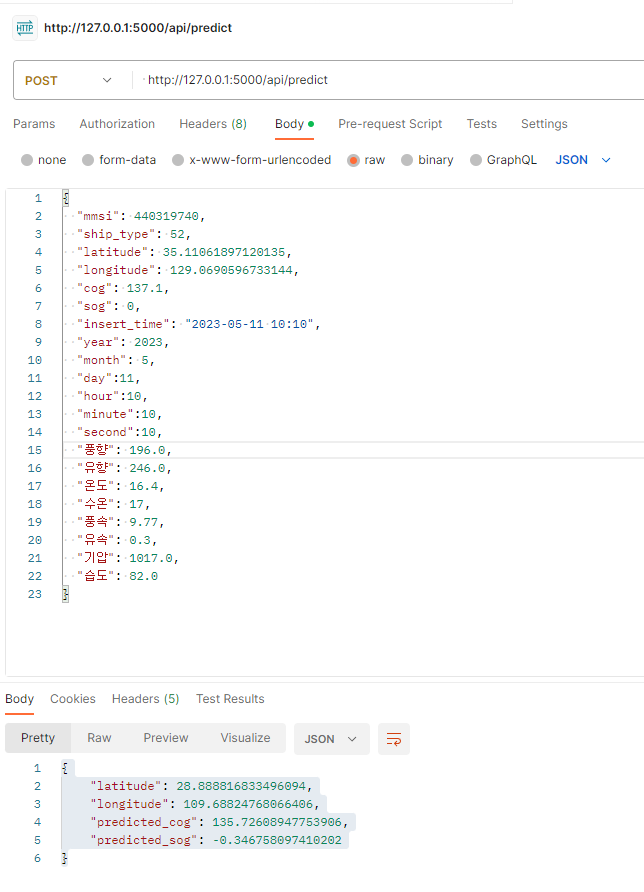

 ### 3) LSTM+CNN 회귀 모델 

In [1]:
# LSTM + CNN
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from pyproj import Transformer

import binascii
from shapely import wkb
import pyproj

def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱 
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)

        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    

# CSV 파일에서 데이터 로드
data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_114714.csv', encoding='ANSI')

# 특정 칼럼의 조건에 따라 데이터 필터링
filtered_data = data[data['sog'] > 3]  # 특정 칼럼과 조건을 적절히 수정해야 합니다

data= filtered_data

# 특정 칼럼의 조건에 따라 데이터 필터링
filtered_data = data[data['sog'] > 3]  # 특정 칼럼과 조건을 적절히 수정해야 합니다

data= filtered_data


# 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

#print(data[['latitude', 'longitude']])

# "insert_time"을 숫자로 변환
data['year'] = pd.to_datetime(data['insert_time']).dt.year
data['month'] = pd.to_datetime(data['insert_time']).dt.month
data['day'] = pd.to_datetime(data['insert_time']).dt.day
data['hour'] = pd.to_datetime(data['insert_time']).dt.hour
data['minute'] = pd.to_datetime(data['insert_time']).dt.minute
data['second'] = pd.to_datetime(data['insert_time']).dt.minute


# 특성과 타겟 변수 선택
X = data[["mmsi", "ship_type", "latitude", "longitude", "cog", "sog", "year", "month", "day", "hour", "minute", "second", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]

# 각 변수에 대한 타겟 변수 선택
y_latitude = data[["latitude"]]
y_longitude = data[["longitude"]]
y_cog = data[["cog"]]
y_sog = data[["sog"]]

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_latitude_train, y_latitude_test, y_longitude_train, y_longitude_test, y_cog_train, y_cog_test, y_sog_train, y_sog_test = train_test_split(X, y_latitude, y_longitude, y_cog, y_sog, test_size=0.2, random_state=42)

# MinMaxScaler를 사용하여 입력 특성 스케일 조정
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM에 맞게 입력 데이터 형태 변환
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# LSTM과 CNN을 결합한 모델 생성
model_latitude = Sequential()
model_longitude = Sequential()
model_cog = Sequential()
model_sog = Sequential()

# Conv1D 레이어를 추가합니다. 1D 컨볼루션 연산을 수행하는 레이어로, 입력 데이터의 필터 수는 64개, 커널 크기는 3입니다. 활성화 함수로는 ReLU를 사용하고, 입력 형태는 X_train_reshaped의 shape[1]과 shape[2]에 해당합니다.
model_latitude.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_longitude.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_cog.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_sog.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

# LSTM은 순환 신경망의 한 종류로, 입력 데이터에 대한 장기 의존성을 모델링하는 데 사용됩니다. 이 레이어의 뉴런 수는 64개
model_latitude.add(LSTM(64))
model_longitude.add(LSTM(64))
model_cog.add(LSTM(64))
model_sog.add(LSTM(64))

# Dense 레이어를 추가합니다. 출력층으로 사용되며, 뉴런 수는 1개입니다. 각각의 모델에 대해 예측을 수행하므로 출력은 1개
model_latitude.add(Dense(1))
model_longitude.add(Dense(1))
model_cog.add(Dense(1))
model_sog.add(Dense(1))

# 모델 컴파일
model_latitude.compile(loss='mse', optimizer='adam')
model_longitude.compile(loss='mse', optimizer='adam')
model_cog.compile(loss='mse', optimizer='adam')
model_sog.compile(loss='mse', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='min')


# 모델 훈련
history_latitude = model_latitude.fit(X_train_reshaped, y_latitude_train, epochs=30, batch_size=32, validation_data=(X_test_reshaped, y_latitude_test))
history_longitude = model_longitude.fit(X_train_reshaped, y_longitude_train, epochs=30, batch_size=32, validation_data=(X_test_reshaped, y_longitude_test))
history_cog = model_cog.fit(X_train_reshaped, y_cog_train, epochs=30, batch_size=32, validation_data=(X_test_reshaped, y_cog_test))
history_sog = model_sog.fit(X_train_reshaped, y_sog_train, epochs=30, batch_size=32, validation_data=(X_test_reshaped, y_sog_test))

# 모델을 사용하여 예측 수행
y_latitude_pred = model_latitude.predict(X_test_reshaped)
y_longitude_pred = model_longitude.predict(X_test_reshaped)
y_cog_pred = model_cog.predict(X_test_reshaped)
y_sog_pred = model_sog.predict(X_test_reshaped)

# Convert predictions to a list
y_latitude_pred_list = y_latitude_pred.tolist()
y_longitude_pred_list = y_longitude_pred.tolist()
y_cog_pred_list = y_cog_pred.tolist()
y_sog_pred_list = y_sog_pred.tolist()

# 평균 제곱 오차 계산
mse_latitude = mean_squared_error(y_latitude_test, y_latitude_pred)
mse_longitude = mean_squared_error(y_longitude_test, y_longitude_pred)
mse_cog = mean_squared_error(y_cog_test, y_cog_pred)
mse_sog = mean_squared_error(y_sog_test, y_sog_pred)

print("Mean Squared Error - Latitude:", mse_latitude)
print("Mean Squared Error - Longitude:", mse_longitude)
print("Mean Squared Error - COG:", mse_cog)
print("Mean Squared Error - SOG:", mse_sog)

# Create the response JSON
response = {
    "latitude": y_latitude_pred_list[0][0],
    "longitude": y_longitude_pred_list[0][0],
    "predicted_cog": y_cog_pred_list[0][0],
    "predicted_sog": y_sog_pred_list[0][0]
}

print(response)

Epoch 1/30
3842/3842 [==============================] - 22s 5ms/step - loss: 31.7209 - val_loss: 0.0634
Epoch 2/30
3842/3842 [==============================] - 21s 5ms/step - loss: 0.0600 - val_loss: 0.0629
Epoch 3/30
3842/3842 [==============================] - 21s 5ms/step - loss: 0.0586 - val_loss: 0.0611
Epoch 4/30
3842/3842 [==============================] - 22s 6ms/step - loss: 0.0587 - val_loss: 0.0623
Epoch 5/30
3842/3842 [==============================] - 22s 6ms/step - loss: 0.0586 - val_loss: 0.0618
Epoch 6/30
3842/3842 [==============================] - 24s 6ms/step - loss: 0.6734 - val_loss: 0.0632
Epoch 7/30
3842/3842 [==============================] - 25s 6ms/step - loss: 0.0585 - val_loss: 0.0606
Epoch 8/30
3842/3842 [==============================] - 25s 6ms/step - loss: 0.0584 - val_loss: 0.0605
Epoch 9/30
3842/3842 [==============================] - 23s 6ms/step - loss: 0.0584 - val_loss: 0.0606
Epoch 10/30
3842/3842 [==============================] - 24s 6ms/step - 

In [2]:
import pickle

# 모델 저장
with open('model_latitude02.pkl', 'wb') as f:
    pickle.dump(model_latitude, f)

with open('model_longitude02.pkl', 'wb') as f:
    pickle.dump(model_longitude, f)

with open('model_cog02.pkl', 'wb') as f:
    pickle.dump(model_cog, f)

with open('model_sog02.pkl', 'wb') as f:
    pickle.dump(model_sog, f)

# 모델 불러오기
with open('model_latitude02.pkl', 'rb') as f:
    model_latitude = pickle.load(f)

with open('model_longitude02.pkl', 'rb') as f:
    model_longitude = pickle.load(f)

with open('model_cog02.pkl', 'rb') as f:
    model_cog = pickle.load(f)

with open('model_sog02.pkl', 'rb') as f:
    model_sog = pickle.load(f)

![](../data_image/)

평균 제곱 오차(MSE) 값은 경도, COG 및 SOG에 대한 예측 값과 실제 값 사이의 평균 제곱 차이 측정값을 제공합니다. MSE가 낮을수록 모델이 데이터에 더 적합함을 나타냅니다. 제공한 MSE 값을 분석해 보겠습니다.


평균 제곱 오차 - 경도: 0.08056472066281514


이 MSE 값은 예측된 경도 값과 실제 경도 값 사이의 평균 제곱 차이를 측정합니다.
상대적으로 낮은 MSE는 모델이 경도 예측에 적합함을 나타냅니다.
그러나 이 MSE의 실질적인 의미를 결정하기 위해서는 경도 값의 척도와 단위를 고려하는 것이 중요합니다.

평균 제곱 오차 - COG: 0.11326184436024221


이 MSE 값은 예측과 실제 COG(Course Over Ground) 값 사이의 평균 제곱 차이를 측정합니다.
경도와 유사하게 상대적으로 낮은 MSE는 모델이 COG 예측에서 상당히 잘 수행되고 있음을 나타냅니다.
다시 말하지만, 이 MSE의 중요성을 해석하려면 특정 도메인과 컨텍스트를 고려하는 것이 중요합니다.

평균 제곱 오차 - SOG: 0.03185195181749647


이 MSE 값은 예측 및 실제 SOG(Speed ​​Over Ground) 값 사이의 평균 제곱 차이를 측정합니다.
더 낮은 MSE는 모델이 SOG를 예측하는 데 매우 잘 수행되고 있음을 나타냅니다.
상대적으로 낮은 MSE는 SOG에 대한 모델의 예측이 실제 값과 거의 일치함을 나타냅니다.


### 04) GradientBoostingRegressor 모델

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import binascii
from shapely import wkb
import pyproj
from pyproj import Transformer

def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        #transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)
   
        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    
# Load data from CSV file
data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_1147142.csv', encoding='ANSI')

# 특정 칼럼의 조건에 따라 데이터 필터링
filtered_data = data[data['sog'] > 3]  # 특정 칼럼과 조건을 적절히 수정해야 합니다

data= filtered_data

# 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

# "insert_time"을 숫자로 변환
data['year'] = pd.to_datetime(data['insert_time']).dt.year
data['month'] = pd.to_datetime(data['insert_time']).dt.month
data['day'] = pd.to_datetime(data['insert_time']).dt.day
data['hour'] = pd.to_datetime(data['insert_time']).dt.hour
data['minute'] = pd.to_datetime(data['insert_time']).dt.minute
data['second'] = pd.to_datetime(data['insert_time']).dt.minute

# 특성 선택

X = data[["mmsi", "ship_type", "latitude","longitude", "cog", "sog", "year", "month", "day", "hour", "minute", "second", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]

print(X)

# 타겟 변수 선택
y_latitude = data["latitude"]  # 원래 데이터셋의 Latitude 값
y_longitude = data["longitude"]  # 원래 데이터셋의 Longitude 값
y_cog = data["cog"]  # 원래 데이터셋의 COG 값
y_sog = data["sog"]  # 원래 데이터셋의 SOG 값

# 데이터를 교육 및 테스트 세트로 분할
X_train, X_test, y_latitude_train, y_latitude_test, y_longitude_train, y_longitude_test, y_cog_train, y_cog_test, y_sog_train, y_sog_test = train_test_split(
    X, y_latitude, y_longitude, y_cog, y_sog, test_size=0.2, random_state=42
)

# Latitude 모델 훈련 및 예측
model_latitude = GradientBoostingRegressor()
model_latitude.fit(X_train, y_latitude_train)
y_latitude_pred = model_latitude.predict(X_test)

# Longitude 모델 훈련 및 예측
model_longitude = GradientBoostingRegressor()
model_longitude.fit(X_train, y_longitude_train)
y_longitude_pred = model_longitude.predict(X_test)

# COG 모델 훈련 및 예측
model_cog = GradientBoostingRegressor()
model_cog.fit(X_train, y_cog_train)
y_cog_pred = model_cog.predict(X_test)

# SOG 모델 훈련 및 예측
model_sog = GradientBoostingRegressor()
model_sog.fit(X_train, y_sog_train)
y_sog_pred = model_sog.predict(X_test)

# 정확도 예측
mse_latitude = mean_squared_error(y_latitude_test, y_latitude_pred)
mse_longitude = mean_squared_error(y_longitude_test, y_longitude_pred)
mse_cog = mean_squared_error(y_cog_test, y_cog_pred)
mse_sog = mean_squared_error(y_sog_test, y_sog_pred)

# 예측된 Latitude, Longitude, COG, SOG 값을 출력
print("Predicted Latitude:", y_latitude_pred)
print("Predicted Longitude:", y_longitude_pred)
print("Predicted COG:", y_cog_pred)
print("Predicted SOG:", y_sog_pred)

# 정확도 예측
print("MSE Latitude:", mse_latitude)
print("MSE Longitude:", mse_longitude)
print("MSE COG:", mse_cog)
print("MSE SOG:", mse_sog)


            mmsi  ship_type   latitude   longitude    cog   sog  year  month   
0      440051540          0  35.039909  129.062547  329.2   5.7  2023      5  \
5      538010219          0  34.882612  129.060553  212.2  16.1  2023      5   
17     440051540          0  35.039909  129.062547  329.2   5.7  2023      5   
19     440102990          0  35.099860  129.041436   42.6   8.8  2023      5   
20     440048210         80  35.064618  129.110167   31.6   9.6  2023      5   
...          ...        ...        ...         ...    ...   ...   ...    ...   
52705  440135680          0  34.958493  129.193000  306.5  10.1  2023      5   
52708  440658000         70  35.042145  129.170300  239.4   7.5  2023      5   
52709  440761000         71  35.019416  129.126246  210.0   7.6  2023      5   
52714  440003510          0  35.035548  129.038131   90.6  15.3  2023      5   
52726  563156900         71  34.813431  129.000033   49.5  11.8  2023      5   

       day  hour  minute  second   풍향  

![](../data_image/GradientBoostingRegressor%EA%B7%B8%EB%9E%98%ED%94%84%EC%9D%B4%EB%AF%B8%EC%A7%80.PNG)

### 1. 1시간의 데이터가 아닌 7시간의 데이터를 학습모델의 데이터로 사용
### 2. 예측하고 하는 latitude, longitude, cog, sog의 값을 각각으 모델로 만들어 정확도를 높임 

### 3.추가적으로 sog>3 , 하루치 데이터 학습

#### MSE Latitude: 8.141836418187882e-06 =>  5.189103130959642e-06
위도(Latitude)의 예측 값과 실제 값 사이의 평균 제곱 오차(MSE)는 매우 작은 값입니다. 이는 모델이 위도를 정확하게 예측하는 데 성공했음을 나타냅니다.

#### MSE Longitude: 2.2479064275089946e-05 =>  1.0078660689818846e-05
경도(Longitude)의 예측 값과 실제 값 사이의 MSE는 위도에 비해 크지만 여전히 매우 작은 값입니다. 따라서 모델은 경도를 상당히 정확하게 예측할 수 있었을 것으로 보입니다.


#### MSE COG: 0.4436597293301889 => 0.4629109252743415
COG(선속방향)의 예측 값과 실제 값 사이의 MSE는 상대적으로 큰 값입니다. 이는 모델이 COG를 예측하는 데 어려움을 겪었을 가능성이 있습니다. COG는 다른 특성들에 비해 예측하기 어려운 변수일 수 있습니다.

#### MSE SOG: 0.000632866761406288 =>  0.03055722408141932
SOG(선속)의 예측 값과 실제 값 사이의 MSE는 COG보다는 작지만 여전히 상당한 값입니다. 모델이 SOG를 상대적으로 정확하게 예측하지 못했을 가능성이 있습니다.

분석 결과, 위도와 경도의 예측 값의 MSE가 매우 작아 정확한 예측이 이루어졌지만, COG와 SOG의 예측 값의 MSE가 상대적으로 크므로 해당 변수들을 예측하는 데는 아직 개선의 여지가 있을 수 있습니다. 추가적인 데이터 처리나 모델 튜닝 등을 통해 모델의 성능을 더욱 개선할 수 있을 것입니다.